In [1]:
!pip install  -q 'ibis-framework[mssql]'
%pip install  -q altair

StatementMeta(, 04c616c7-4471-44f4-b122-e3f2e75308b4, 8, Finished, Available, Finished)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 2.0.0 requires sentencepiece, which is not installed.
sentence-transformers 2.0.0 requires torchvision, which is not installed.
dash 2.14.0 requires Flask<2.3.0,>=1.0.4, but you have flask 3.0.0 which is incompatible.
dash 2.14.0 requires Werkzeug<2.3.0, but you have werkzeug 3.0.1 which is incompatible.
tensorflow 2.12.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



In [2]:
endpoint = 'xxxxxxxxxxxxxxxxxxx.datawarehouse.fabric.microsoft.com'
catalog  = 'dwh'

StatementMeta(, 04c616c7-4471-44f4-b122-e3f2e75308b4, 10, Finished, Available, Finished)

**_<u><mark>Get connection</mark></u>_**

In [3]:
import ibis, sqlglot
from ibis.expr.visualize import to_graph
def get_ibis_connection(endpoint ,catalog ):
    import ibis
    import struct , pyodbc , ibis.backends.mssql
    dwh_backend = ibis.backends.mssql.Backend()
    token = notebookutils.credentials.getToken('https://analysis.windows.net/powerbi/api').encode("UTF-16-LE")
    token_struct = struct.pack(f'<I{len(token)}s', len(token), token)
    dwh_backend.con = pyodbc.connect(f"Driver={{ODBC Driver 18 for SQL Server}};Server={endpoint},1433;Encrypt=Yes;TrustServerCertificate=No", attrs_before={1256: token_struct})
    dwh_backend.raw_sql(f" use {catalog};")
    return dwh_backend
def sql_to_df(query,endpoint=endpoint, catalog = catalog ):
    con = get_ibis_connection(endpoint = endpoint,catalog = catalog)
    standard_sql = sqlglot.transpile(query, read= 'tsql', write='tsql')[0]
    import pyarrow as pa
    cursor = con.raw_sql(standard_sql)
    columns = [column[0] for column in cursor.description]
    data = cursor.fetchall()
    columnar_data = list(zip(*data))
    arrow_table = pa.Table.from_arrays([pa.array(col) for col in columnar_data], columns)
    return arrow_table

StatementMeta(, 04c616c7-4471-44f4-b122-e3f2e75308b4, 11, Finished, Available, Finished)

# SQL

In [11]:
sql = """   -- top do nothing, just want to use a tsql specific code
            SELECT  top 30000
            date ,
            SUM(fare_amount) AS totalfares ,
            AVG(fare_amount) AS avgfares
            from ny.taxi 
            group by date
            order by date desc
      """
data = sql_to_df(sql,endpoint , catalog)

StatementMeta(, 04c616c7-4471-44f4-b122-e3f2e75308b4, 19, Finished, Available, Finished)

In [12]:
import altair as alt
brush = alt.selection_interval()
details = alt.Chart(data).mark_bar().encode(alt.X('date:T'),  alt.Y('totalfares:Q'), tooltip=[alt.Tooltip('date:T',format='%Y-%m-%d %H'),'totalfares:Q']
).properties( width=1400,  height=400 ).add_params( brush)

summary = alt.Chart(data).mark_square().encode( alt.X('date:T'), alt.Y('avgfares:Q'), tooltip=['avgfares:Q'] ).properties(  width=1400,  height=400).transform_filter( brush)
details & summary

StatementMeta(, 04c616c7-4471-44f4-b122-e3f2e75308b4, 20, Finished, Available, Finished)

alt.VConcatChart(...)

# Dataframe API

In [6]:
con = get_ibis_connection(endpoint=endpoint, catalog = catalog )

StatementMeta(, 04c616c7-4471-44f4-b122-e3f2e75308b4, 14, Finished, Available, Finished)

In [7]:
taxi = con.table(name="taxi", database='ny')
agg = taxi.filter(taxi.year == 2024).group_by("date").aggregate(totalfares=taxi.fare_amount.sum(), avgfares=taxi.fare_amount.mean())
ibis.to_sql(agg)

StatementMeta(, 04c616c7-4471-44f4-b122-e3f2e75308b4, 15, Finished, Available, Finished)

```sql
SELECT
  [t1].[date],
  SUM([t1].[fare_amount]) AS [totalfares],
  AVG([t1].[fare_amount]) AS [avgfares]
FROM (
  SELECT
    [t0].[trip_distance],
    [t0].[store_and_fwd_flag],
    [t0].[fare_amount],
    [t0].[extra],
    [t0].[mta_tax],
    [t0].[tip_amount],
    [t0].[tolls_amount],
    [t0].[improvement_surcharge],
    [t0].[total_amount],
    [t0].[airport_fee],
    [t0].[congestion_surcharge],
    [t0].[vendorid],
    [t0].[passenger_count],
    [t0].[pulocationid],
    [t0].[dolocationid],
    [t0].[payment_type],
    [t0].[ratecodeid],
    [t0].[tpep_pickup_datetime],
    [t0].[tpep_dropoff_datetime],
    [t0].[hour],
    [t0].[date],
    [t0].[file],
    [t0].[year]
  FROM [ny].[taxi] AS [t0]
  WHERE
    [t0].[year] = 2024
) AS [t1]
GROUP BY
  [t1].[date]
```

In [8]:
con.list_databases()

StatementMeta(, 04c616c7-4471-44f4-b122-e3f2e75308b4, 16, Finished, Available, Finished)

['INFORMATION_SCHEMA',
 '_rsc',
 'db_accessadmin',
 'db_backupoperator',
 'db_datareader',
 'db_datawriter',
 'db_ddladmin',
 'db_denydatareader',
 'db_denydatawriter',
 'db_owner',
 'db_securityadmin',
 'dbo',
 'guest',
 'ny',
 'queryinsights',
 'sys',
 'xxxxxxxxxxxxxxx']

StatementMeta(, 04c616c7-4471-44f4-b122-e3f2e75308b4, 17, Finished, Available, Finished)

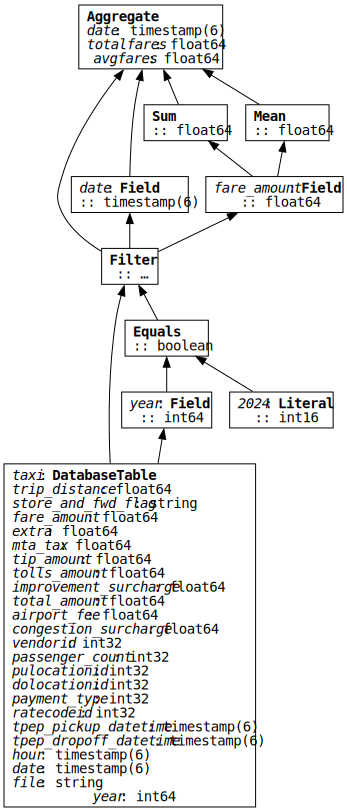

In [9]:
to_graph(agg)

In [10]:
import altair as alt
brush = alt.selection_interval()
details = alt.Chart(agg).mark_bar().encode(alt.X('date:T'),  alt.Y('totalfares:Q'), tooltip=[alt.Tooltip('date:T',format='%Y-%m-%d %H'),'totalfares:Q']
).properties( width=1400,  height=400 ).add_params( brush)

summary = alt.Chart(agg).mark_square().encode( alt.X('date:T'), alt.Y('avgfares:Q'), tooltip=['avgfares:Q'] ).properties(  width=1400,  height=400).transform_filter( brush)
details & summary

StatementMeta(, 04c616c7-4471-44f4-b122-e3f2e75308b4, 18, Finished, Available, Finished)

alt.VConcatChart(...)